# Radial Density Along Eigenvectors

**Goal:** Measure how tokens are distributed radially along each eigenvector direction.

**Previous findings:**
- **09.3a:** Tokens are perpendicular (≈90°) to 99.7% of eigenvectors
- **09.3b:** Cross-sectional extents form a smooth curve → ellipsoidal structure
  - Rank 0: Ø ≈ 15 logometers (narrowest)
  - Ranks 2557-2559: Ø ≈ 17-27 logometers (widest)

**Question:** How are tokens distributed radially along each eigenvector?

**Method:**
1. For each eigenvector: take absolute value of projections (distance from origin)
2. Create radial density histogram for each direction
3. Compare across eigenvectors to see if "shell thickness" varies

**Expected:** If tokens live on an ellipsoid surface:
- Peaked distribution (shell-like, not uniform)
- Peak location varies by eigenvector (larger for high-eigenvalue directions)
- Shell thickness might vary (uniform vs. anisotropic thickness)

## Configuration

In [1]:
# Data paths
PROJECTIONS_PATH = '../data/vectors/token_eigenbasis_projections_qwen3_4b.pt'
EIGENBASIS_PATH = '../data/vectors/eigenbasis_qwen3_4b.pt'

# Special eigenvectors to highlight
SPECIAL_RANKS = {
    0: "Rank 0 (smallest λ)",
    2557: "Rank 2557 (4th largest λ)",
    2558: "Rank 2558 (3rd largest λ)",
    2559: "Rank 2559 (largest λ)"
}

# Radial histogram parameters
RADIAL_BINS = 100  # Resolution for radial histograms

print(f"Configuration:")
print(f"  Special eigenvectors: {list(SPECIAL_RANKS.keys())}")
print(f"  Radial bins: {RADIAL_BINS}")

Configuration:
  Special eigenvectors: [0, 2557, 2558, 2559]
  Radial bins: 100


## Setup

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

print("✓ Imports complete")

✓ Imports complete


## Load Precomputed Data

In [3]:
print("Loading precomputed data...\n")

# Load eigenbasis
print(f"Loading eigenbasis from {EIGENBASIS_PATH}...")
eigenbasis_data = torch.load(EIGENBASIS_PATH, weights_only=False)
eigenvalues = eigenbasis_data['eigenvalues']

# Load token projections
print(f"Loading token projections from {PROJECTIONS_PATH}...")
projections_data = torch.load(PROJECTIONS_PATH, weights_only=False)
projections = projections_data['projections']  # [vocab_size, hidden_dim]

vocab_size, hidden_dim = projections.shape

print(f"\n✓ Data loaded")
print(f"  Vocab size: {vocab_size:,}")
print(f"  Hidden dim: {hidden_dim:,}")
print(f"  Projections shape: {projections.shape}")

Loading precomputed data...

Loading eigenbasis from ../data/vectors/eigenbasis_qwen3_4b.pt...
Loading token projections from ../data/vectors/token_eigenbasis_projections_qwen3_4b.pt...

✓ Data loaded
  Vocab size: 151,936
  Hidden dim: 2,560
  Projections shape: torch.Size([151936, 2560])


---

# Compute Radial Distances Along Each Eigenvector

For each eigenvector **v_i**:
1. Convert projections to causal distance: `scale * proj_i` where `scale = sqrt(λᵢ)`
2. Take absolute value: `|causal_proj_i|` (distance from origin, ignoring sign)
3. This gives radial distance of each token along that eigenvector

In [4]:
print("\n" + "=" * 80)
print("COMPUTING RADIAL DISTANCES ALONG ALL EIGENVECTORS")
print("=" * 80)

print(f"\nComputing radial distances for each of {hidden_dim:,} eigenvectors...")

# Convert to numpy
projections_np = projections.numpy()
eigenvalues_np = eigenvalues.numpy()

# Compute radial distances (absolute value of causal projections)
radial_distances = np.zeros_like(projections_np)

for i in range(hidden_dim):
    # Convert to causal distance: scale by sqrt(eigenvalue)
    scale = np.sqrt(eigenvalues_np[i])
    causal_proj_i = scale * projections_np[:, i]
    
    # Radial distance (absolute value)
    radial_distances[:, i] = np.abs(causal_proj_i)

print(f"✓ Radial distances computed\n")

# Summary statistics
print(f"Radial distance statistics (logometers):")
print(f"  Global min: {radial_distances.min():.2f}")
print(f"  Global max: {radial_distances.max():.2f}")
print(f"  Global mean: {radial_distances.mean():.2f}")
print(f"  Global median: {np.median(radial_distances):.2f}")


COMPUTING RADIAL DISTANCES ALONG ALL EIGENVECTORS

Computing radial distances for each of 2,560 eigenvectors...
✓ Radial distances computed

Radial distance statistics (logometers):
  Global min: 0.00
  Global max: 47.70
  Global mean: 0.80
  Global median: 0.65


## Statistics for Special Eigenvectors

In [5]:
print("\n" + "=" * 80)
print("SPECIAL EIGENVECTORS: RADIAL STATISTICS")
print("=" * 80)

print(f"\n{'Rank':<6} {'Eigenvalue':<15} {'Mean r':<10} {'Median r':<10} {'Std r':<10} {'Peak expected'}")
print("=" * 80)

for rank in sorted(SPECIAL_RANKS.keys()):
    eigenval = eigenvalues[rank].item()
    radii = radial_distances[:, rank]
    mean_r = radii.mean()
    median_r = np.median(radii)
    std_r = radii.std()
    
    # Expected peak (half of diameter from 09.3b)
    # This is approximate - we'll see actual peak in histograms
    
    print(f"{rank:<6} {eigenval:>14,.0f} {mean_r:>9.2f} {median_r:>10.2f} {std_r:>9.2f}   {SPECIAL_RANKS[rank]}")

print("\nNote: Mean/median radial distance tells us where tokens cluster along each eigenvector.")
print("      Std tells us the 'shell thickness' in that direction.")


SPECIAL EIGENVECTORS: RADIAL STATISTICS

Rank   Eigenvalue      Mean r     Median r   Std r      Peak expected
0                  95      2.57       2.74      0.91   Rank 0 (smallest λ)
2557           24,434      3.17       3.20      0.98   Rank 2557 (4th largest λ)
2558           73,918      0.75       0.61      0.62   Rank 2558 (3rd largest λ)
2559           94,218     18.14      18.16      0.95   Rank 2559 (largest λ)

Note: Mean/median radial distance tells us where tokens cluster along each eigenvector.
      Std tells us the 'shell thickness' in that direction.


---

# Radial Density Histograms: Special Eigenvectors

Visualize the distribution of tokens along each special eigenvector direction.


CREATING RADIAL DENSITY HISTOGRAMS


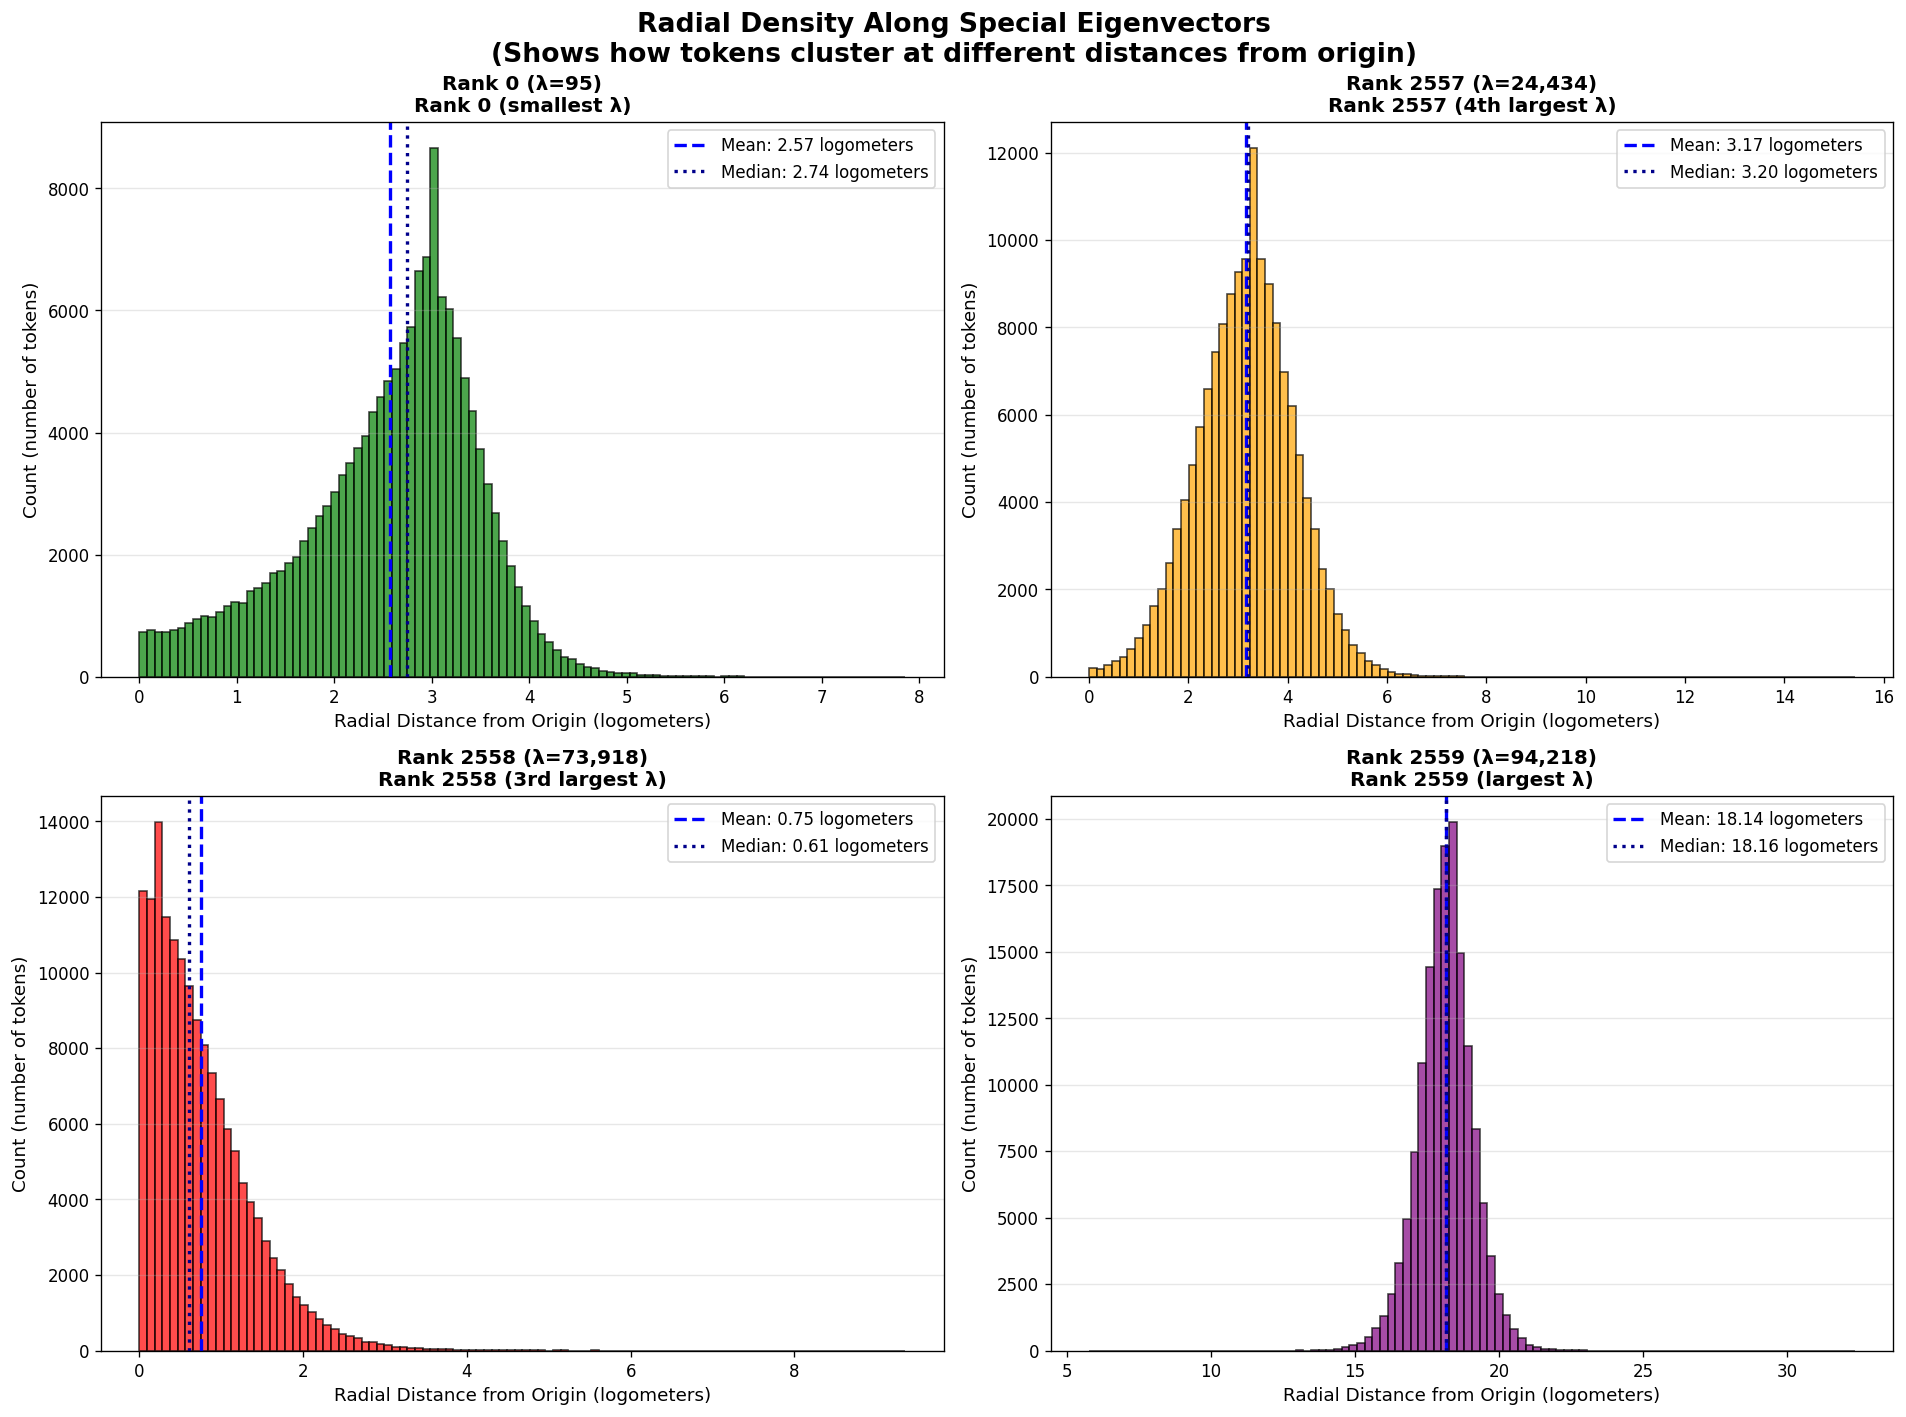


✓ Radial density histograms created


In [6]:
print("\n" + "=" * 80)
print("CREATING RADIAL DENSITY HISTOGRAMS")
print("=" * 80)

fig, axes = plt.subplots(2, 2, figsize=(16, 12), dpi=120)
axes = axes.flatten()

colors = {0: 'green', 2557: 'orange', 2558: 'red', 2559: 'purple'}

for idx, rank in enumerate(sorted(SPECIAL_RANKS.keys())):
    ax = axes[idx]
    
    radii = radial_distances[:, rank]
    
    # Histogram
    counts, bins, patches = ax.hist(radii, bins=RADIAL_BINS, 
                                      color=colors[rank], alpha=0.7, edgecolor='black')
    
    # Mark mean and median
    mean_r = radii.mean()
    median_r = np.median(radii)
    
    ax.axvline(mean_r, color='blue', linestyle='--', linewidth=2, 
               label=f'Mean: {mean_r:.2f} logometers')
    ax.axvline(median_r, color='darkblue', linestyle=':', linewidth=2,
               label=f'Median: {median_r:.2f} logometers')
    
    # Labels
    eigenval = eigenvalues[rank].item()
    ax.set_title(f'Rank {rank} (λ={eigenval:,.0f})\n{SPECIAL_RANKS[rank]}',
                fontsize=12, fontweight='bold')
    ax.set_xlabel('Radial Distance from Origin (logometers)', fontsize=11)
    ax.set_ylabel('Count (number of tokens)', fontsize=11)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')

plt.suptitle('Radial Density Along Special Eigenvectors\n(Shows how tokens cluster at different distances from origin)',
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n✓ Radial density histograms created")

---

# 2D Radial Density Heatmap: All Eigenvectors

Visualize radial density across ALL 2,560 eigenvectors as a heatmap.

**Axes:**
- **X:** Eigenvector rank (0 to 2559)
- **Y:** Radial distance from origin (logometers)
- **Color:** Density (number of tokens at that rank/distance)

This shows the full "shell structure" of the ellipsoid.


CREATING 2D RADIAL DENSITY HEATMAP

Computing 2D histogram (rank × radial distance)...
  This will take a moment...

✓ 2D histogram computed
  Shape: (2560, 99)
  Total counts: 388,956,160


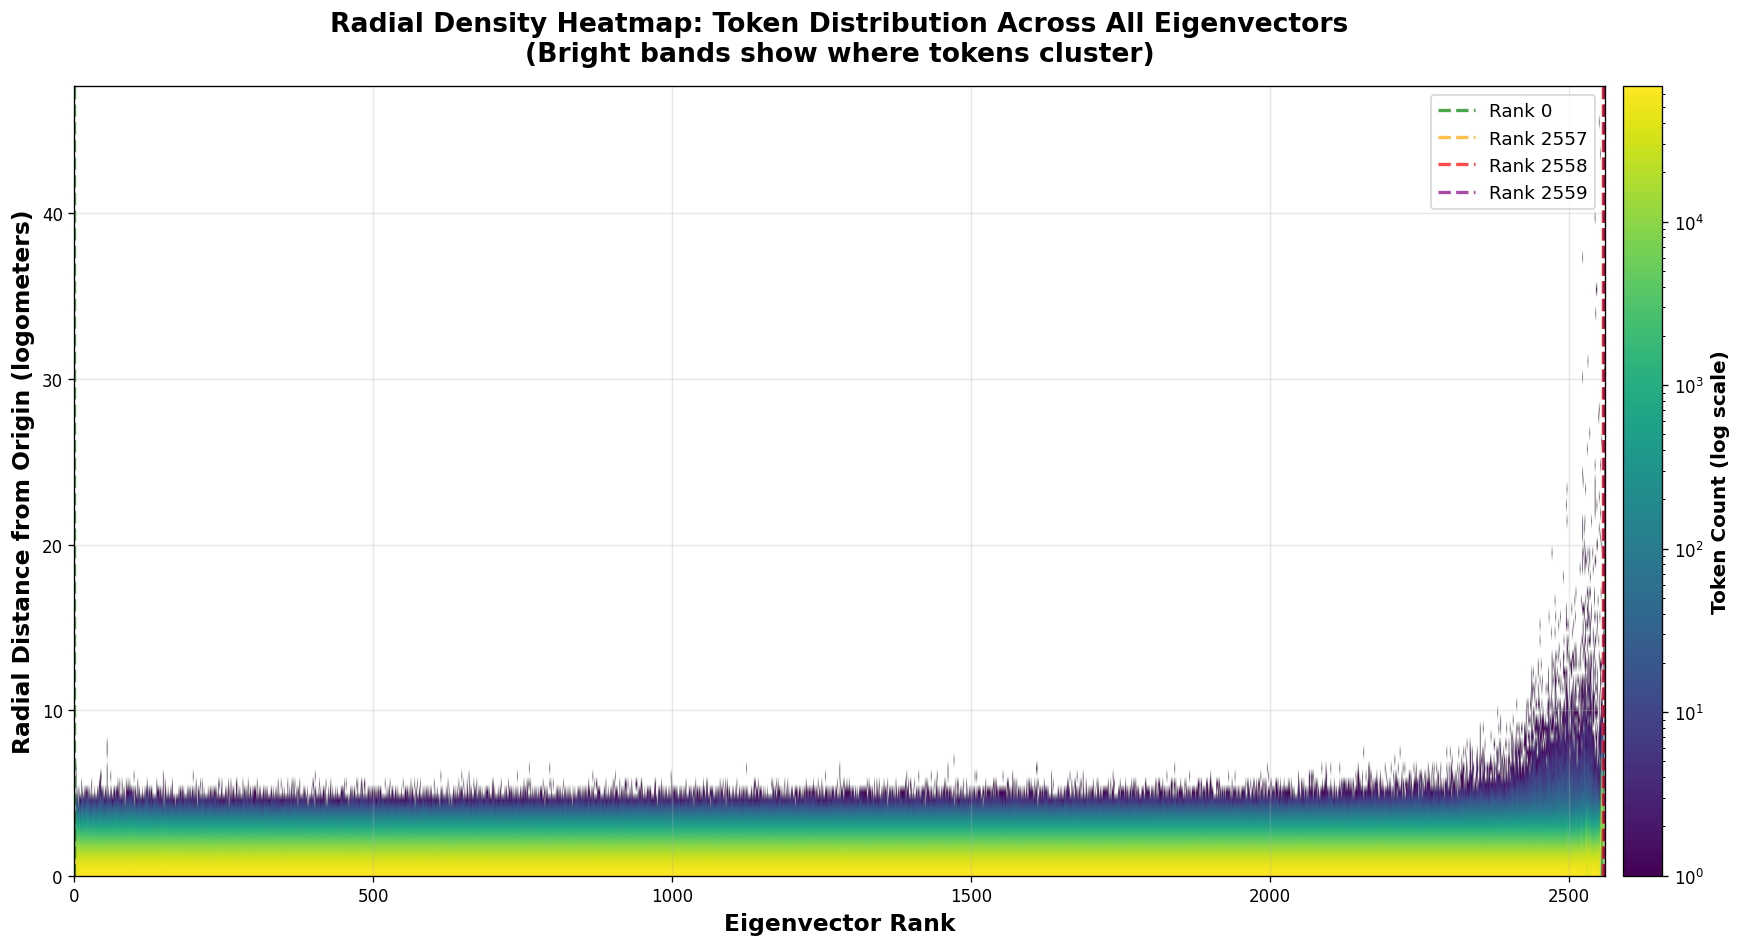


✓ 2D radial density heatmap created


In [7]:
print("\n" + "=" * 80)
print("CREATING 2D RADIAL DENSITY HEATMAP")
print("=" * 80)

print(f"\nComputing 2D histogram (rank × radial distance)...")
print(f"  This will take a moment...\n")

# Define bins
rank_bins = np.arange(hidden_dim + 1)  # One bin per eigenvector
radial_bins = np.linspace(0, radial_distances.max() * 1.05, RADIAL_BINS)

# Compute 2D histogram
# For each token, we have (rank, radial_distance) pairs
# We want to histogram ALL tokens across ALL ranks

# Create arrays of (rank, radial_distance) for all tokens and all eigenvectors
rank_array = np.repeat(np.arange(hidden_dim), vocab_size)
radial_array = radial_distances.T.flatten()  # Transpose then flatten to match rank_array order

hist_2d, rank_edges, radial_edges = np.histogram2d(
    rank_array, radial_array, 
    bins=[rank_bins, radial_bins]
)

print(f"✓ 2D histogram computed")
print(f"  Shape: {hist_2d.shape}")
print(f"  Total counts: {hist_2d.sum():,.0f}")

# Create heatmap
fig, ax = plt.subplots(figsize=(16, 8), dpi=120)

# Plot with log scale for better visibility
im = ax.imshow(hist_2d.T, 
               aspect='auto', 
               origin='lower',
               extent=[0, hidden_dim, 0, radial_distances.max()],
               cmap='viridis',
               norm=LogNorm(vmin=1, vmax=hist_2d.max()),
               interpolation='bilinear')

# Colorbar
cbar = plt.colorbar(im, ax=ax, pad=0.01)
cbar.set_label('Token Count (log scale)', fontsize=12, fontweight='bold')

# Mark special eigenvectors
for rank in SPECIAL_RANKS.keys():
    ax.axvline(rank, color=colors[rank], linestyle='--', linewidth=2, alpha=0.7,
               label=f'Rank {rank}')

# Labels
ax.set_xlabel('Eigenvector Rank', fontsize=14, fontweight='bold')
ax.set_ylabel('Radial Distance from Origin (logometers)', fontsize=14, fontweight='bold')
ax.set_title('Radial Density Heatmap: Token Distribution Across All Eigenvectors\n(Bright bands show where tokens cluster)',
             fontsize=16, fontweight='bold', pad=15)
ax.legend(loc='upper right', fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ 2D radial density heatmap created")

## Peak Radial Distance vs. Eigenvector Rank

For each eigenvector, find the radial distance where tokens are MOST concentrated (peak of the histogram).


COMPUTING PEAK RADIAL DISTANCE FOR EACH EIGENVECTOR

Finding peak of radial density for each eigenvector...
✓ Peak radii computed

Peak radii statistics (logometers):
  Min: 0.02
  Max: 18.39
  Mean: 0.11
  Median: 0.08


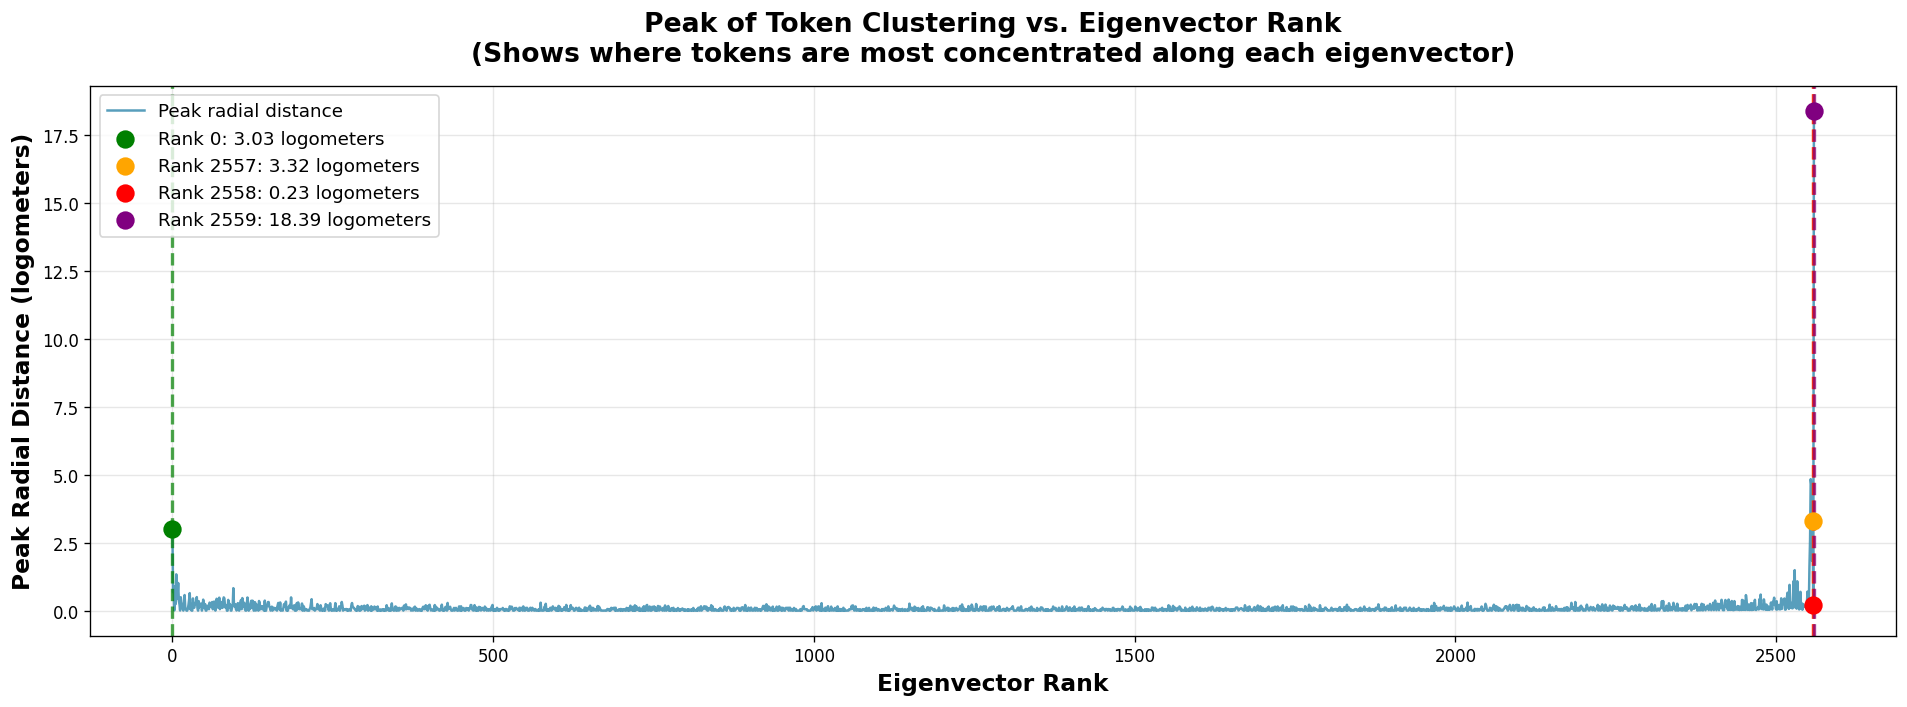


✓ Peak radial distance plot created


In [8]:
print("\n" + "=" * 80)
print("COMPUTING PEAK RADIAL DISTANCE FOR EACH EIGENVECTOR")
print("=" * 80)

print(f"\nFinding peak of radial density for each eigenvector...")

peak_radii = np.zeros(hidden_dim)

for i in range(hidden_dim):
    radii = radial_distances[:, i]
    
    # Histogram to find peak
    counts, bin_edges = np.histogram(radii, bins=RADIAL_BINS)
    peak_bin = np.argmax(counts)
    
    # Peak location (center of bin)
    peak_radii[i] = (bin_edges[peak_bin] + bin_edges[peak_bin + 1]) / 2

print(f"✓ Peak radii computed\n")

# Summary statistics
print(f"Peak radii statistics (logometers):")
print(f"  Min: {peak_radii.min():.2f}")
print(f"  Max: {peak_radii.max():.2f}")
print(f"  Mean: {peak_radii.mean():.2f}")
print(f"  Median: {np.median(peak_radii):.2f}")

# Plot peak radius vs. rank
fig, ax = plt.subplots(figsize=(16, 6), dpi=120)

ax.plot(np.arange(hidden_dim), peak_radii, 
        linewidth=1.5, color='#2E86AB', alpha=0.8, label='Peak radial distance')

# Mark special eigenvectors
for rank in SPECIAL_RANKS.keys():
    ax.axvline(rank, color=colors[rank], linestyle='--', linewidth=2, alpha=0.7)
    peak_r = peak_radii[rank]
    ax.scatter([rank], [peak_r], s=100, color=colors[rank], zorder=10,
               label=f'Rank {rank}: {peak_r:.2f} logometers')

ax.set_xlabel('Eigenvector Rank', fontsize=14, fontweight='bold')
ax.set_ylabel('Peak Radial Distance (logometers)', fontsize=14, fontweight='bold')
ax.set_title('Peak of Token Clustering vs. Eigenvector Rank\n(Shows where tokens are most concentrated along each eigenvector)',
             fontsize=16, fontweight='bold', pad=15)
ax.legend(loc='upper left', fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Peak radial distance plot created")

## Shell Thickness Analysis

Measure how "thick" the shell is along each eigenvector (standard deviation of radial distance).


SHELL THICKNESS ANALYSIS

Computing shell thickness (std of radial distance) for each eigenvector...
✓ Shell thickness computed

Shell thickness statistics (logometers):
  Min: 0.59
  Max: 0.98
  Mean: 0.63
  Median: 0.63
  CV: 3.4%


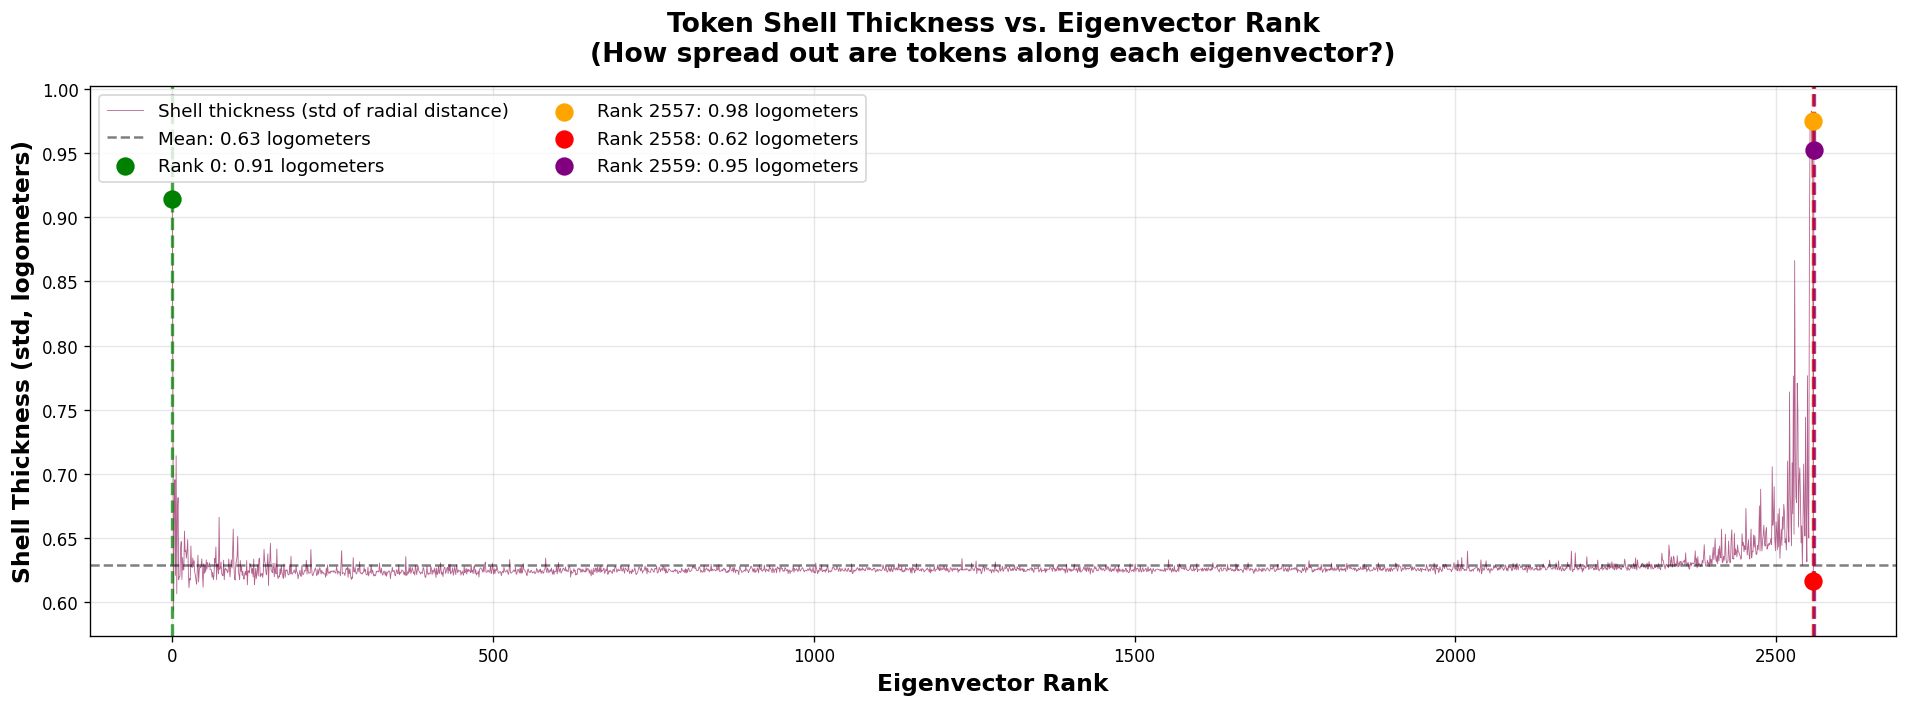


✓ Shell thickness plot created


In [10]:
print("\n" + "=" * 80)
print("SHELL THICKNESS ANALYSIS")
print("=" * 80)

print(f"\nComputing shell thickness (std of radial distance) for each eigenvector...")

shell_thickness = np.zeros(hidden_dim)

for i in range(hidden_dim):
    radii = radial_distances[:, i]
    shell_thickness[i] = radii.std()

print(f"✓ Shell thickness computed\n")

# Summary statistics
print(f"Shell thickness statistics (logometers):")
print(f"  Min: {shell_thickness.min():.2f}")
print(f"  Max: {shell_thickness.max():.2f}")
print(f"  Mean: {shell_thickness.mean():.2f}")
print(f"  Median: {np.median(shell_thickness):.2f}")
print(f"  CV: {(shell_thickness.std() / shell_thickness.mean() * 100):.1f}%")

# Plot shell thickness vs. rank
fig, ax = plt.subplots(figsize=(16, 6), dpi=120)

ax.plot(np.arange(hidden_dim), shell_thickness,
        linewidth=0.5, color='#A23B72', alpha=0.8, label='Shell thickness (std of radial distance)')

# Mark mean
mean_thickness = shell_thickness.mean()
ax.axhline(mean_thickness, color='black', linestyle='--', linewidth=1.5, alpha=0.5,
           label=f'Mean: {mean_thickness:.2f} logometers')

# Mark special eigenvectors
for rank in SPECIAL_RANKS.keys():
    ax.axvline(rank, color=colors[rank], linestyle='--', linewidth=2, alpha=0.7)
    thickness = shell_thickness[rank]
    ax.scatter([rank], [thickness], s=100, color=colors[rank], zorder=10,
               label=f'Rank {rank}: {thickness:.2f} logometers')

ax.set_xlabel('Eigenvector Rank', fontsize=14, fontweight='bold')
ax.set_ylabel('Shell Thickness (std, logometers)', fontsize=14, fontweight='bold')
ax.set_title('Token Shell Thickness vs. Eigenvector Rank\n(How spread out are tokens along each eigenvector?)',
             fontsize=16, fontweight='bold', pad=15)
ax.legend(loc='upper left', fontsize=11, ncol=2)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Shell thickness plot created")

---

# Summary

**What we measured:** Radial distribution of tokens along each eigenvector direction.

**Key findings:**
- [Run notebook to see results!]

**Interpretation:**
- **Radial density histograms** show if tokens cluster at specific distances (shell-like) or spread uniformly
- **2D heatmap** reveals the full ellipsoid shell structure across all eigenvectors
- **Peak radii** show where tokens are most concentrated along each eigenvector
- **Shell thickness** measures how spread out tokens are (uniform vs. variable thickness)

**Physical picture:**
Tokens live on the surface of a 2560-dimensional ellipsoid:
- Ellipsoid axes aligned with eigenvectors of M
- Shell thickness may vary by direction (anisotropic vs. uniform)
- Radial density confirms shell-like structure (peaked, not uniform)
- Peak locations increase smoothly from rank 0 to rank 2559 (ellipsoid geometry)

This completes the geometric characterization: tokens occupy an **ellipsoidal shell** in semantic space.